# Hyperparameter Optimiaztion for Classification with Tabular Data (Tensorflow/Keras2)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/HPS_basic_classification_with_tabular_data/notebook.ipynb)

In this tutorial we present how to use hyperparameter optimization on an example from the Keras documentation.

**Reference**:
 This tutorial is based on materials from the Keras Documentation: [Structured data classification from scratch](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/)

Let us start with installing DeepHyper!
    
<div class="alert alert-warning">

<b>Warning</b>
    
Since the release of **Keras 3.0**, this tutorial should be run with `tf-keras` ([link to pypi](https://pypi.org/project/tf-keras/)).
    
</div>

In [1]:
try:
    import deephyper
    from deephyper.evaluator import RayEvaluator
    print(deephyper.__version__)
except (ImportError, ModuleNotFoundError):
    !pip install "deephyper[tf-keras2,ray]"
    import deephyper
    from deephyper.evaluator import RayEvaluator
    print(deephyper.__version__)


0.9.0


<div class="alert alert-info">
    
<b>Note</b>
    
The following environment variables can be used to avoid the logging of **some** Tensorflow *DEBUG*, *INFO* and *WARNING* statements.
    
</div>

In [2]:
import os


os.environ["TF_CPP_MIN_LOG_LEVEL"] = str(3)
os.environ["AUTOGRAPH_VERBOSITY"] = str(0)

## Imports

The import strategy from the original Keras tutorial (shown below):

```python
from tensorflow import keras
from tensorflow.keras import layers
...
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup
```
    
resulted in non-serializable data, preventing the search from executing in parallel. Therefore, we changed it to take advantage of lazily loading subpackages from Tensorflow.

In [3]:
import json
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import tf_keras as tfk
import tf_keras.backend as K

Then we detect if <b>GPU</b> devices are available on the current host. Therefore, this notebook will automatically adapt the parallel execution based on the resources available locally. However, this simple code will not detect available ressources from multiple nodes.

In [4]:
from tensorflow.python.client import device_lib


def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == "GPU"]


n_gpus = len(get_available_gpus())
if n_gpus > 1:
    n_gpus -= 1
    
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

No GPU available


## The dataset (from Keras.io)

The [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

In [5]:
def load_data():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
    dataframe = pd.read_csv(file_url)

    val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
    train_dataframe = dataframe.drop(val_dataframe.index)

    return train_dataframe, val_dataframe


def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing & encoding of features

The next cells use `tfk.layers.Normalization()` to apply standard scaling on the features.

Then, the `tfk.layers.StringLookup` and `tfk.layers.IntegerLookup` are used to encode categorical variables.

In [6]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = tfk.layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = (
        tfk.layers.StringLookup if is_string else tfk.layers.IntegerLookup
    )
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

## Define the run-function

The run-function defines how the objective that we want to maximize is computed. It takes a `config` dictionary as input and often returns a scalar value that we want to maximize. The `config` contains a sample value of hyperparameters that we want to tune. In this example we will search for:

* `units` (default value: `32`)
* `activation` (default value: `"relu"`)
* `dropout_rate` (default value: `0.5`)
* `num_epochs` (default value: `50`)
* `batch_size` (default value: `32`)
* `learning_rate` (default value: `1e-3`)

A hyperparameter value can be acessed easily in the dictionary through the corresponding key, for example `config["units"]`.

In [7]:
def count_params(model: tfk.Model) -> dict:
    """Evaluate the number of parameters of a Keras model.

    Args:
        model (tfk.Model): a Keras model.

    Returns:
        dict: a dictionary with the number of trainable ``"num_parameters_train"`` and 
        non-trainable parameters ``"num_parameters"``.
    """

    def count_or_null(p):
        try:
            return K.count_params(p)
        except:
            return 0
    
    num_parameters_train = int(
        np.sum([count_or_null(p) for p in model.trainable_weights])
    )
    num_parameters = int(
        np.sum([count_or_null(p) for p in model.non_trainable_weights])
    )
    return {
        "num_parameters": num_parameters,
        "num_parameters_train": num_parameters_train,
    }

In [8]:
def run(config: dict):
    tf.autograph.set_verbosity(0)
    # Load data and split into validation set
    train_dataframe, val_dataframe = load_data()
    train_ds = dataframe_to_dataset(train_dataframe)
    val_ds = dataframe_to_dataset(val_dataframe)
    train_ds = train_ds.batch(config["batch_size"])
    val_ds = val_ds.batch(config["batch_size"])

    # Categorical features encoded as integers
    sex = tfk.Input(shape=(1,), name="sex", dtype="int64")
    cp = tfk.Input(shape=(1,), name="cp", dtype="int64")
    fbs = tfk.Input(shape=(1,), name="fbs", dtype="int64")
    restecg = tfk.Input(shape=(1,), name="restecg", dtype="int64")
    exang = tfk.Input(shape=(1,), name="exang", dtype="int64")
    ca = tfk.Input(shape=(1,), name="ca", dtype="int64")

    # Categorical feature encoded as string
    thal = tfk.Input(shape=(1,), name="thal", dtype="string")

    # Numerical features
    age = tfk.Input(shape=(1,), name="age")
    trestbps = tfk.Input(shape=(1,), name="trestbps")
    chol = tfk.Input(shape=(1,), name="chol")
    thalach = tfk.Input(shape=(1,), name="thalach")
    oldpeak = tfk.Input(shape=(1,), name="oldpeak")
    slope = tfk.Input(shape=(1,), name="slope")

    all_inputs = [
        sex,
        cp,
        fbs,
        restecg,
        exang,
        ca,
        thal,
        age,
        trestbps,
        chol,
        thalach,
        oldpeak,
        slope,
    ]

    # Integer categorical features
    sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
    cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
    fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
    restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
    exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
    ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

    # String categorical features
    thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

    # Numerical features
    age_encoded = encode_numerical_feature(age, "age", train_ds)
    trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
    chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
    thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
    oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
    slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

    all_features = tfk.layers.concatenate(
        [
            sex_encoded,
            cp_encoded,
            fbs_encoded,
            restecg_encoded,
            exang_encoded,
            slope_encoded,
            ca_encoded,
            thal_encoded,
            age_encoded,
            trestbps_encoded,
            chol_encoded,
            thalach_encoded,
            oldpeak_encoded,
        ]
    )
    x = tfk.layers.Dense(config["units"], activation=config["activation"])(
        all_features
    )
    x = tfk.layers.Dropout(config["dropout_rate"])(x)
    output = tfk.layers.Dense(1, activation="sigmoid")(x)
    model = tfk.Model(all_inputs, output)

    optimizer = tfk.optimizers.Adam(learning_rate=config["learning_rate"])
    model.compile(optimizer, "binary_crossentropy", metrics=["accuracy"])

    try:
        history = model.fit(
            train_ds, epochs=config["num_epochs"], validation_data=val_ds, verbose=0
        )
    except:
        class History:
            history = {
                "accuracy": None,
                "val_accuracy": ["F_fit"],
                "loss": None,
                "val_loss": None,
            }

        history = History()


    objective = history.history["val_accuracy"][-1]
    metadata = {
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
    }
    metadata = {k:json.dumps(v) for k,v in metadata.items()}
    metadata.update(count_params(model))

    return {"objective": objective, "metadata": metadata}

<div class="alert alert-info"> 
<b>Note</b>  
<br>

The objective maximised by DeepHyper is the scalar value returned by the `run`-function under the `"objective"` key.
    
</div>

In this tutorial it corresponds to the validation accuracy of the last epoch of training which we retrieve in the `History` object returned by the `model.fit(...)` call.
    
```python
...
history = model.fit(
    train_ds, epochs=config["num_epochs"], validation_data=val_ds, verbose=0
) 
return history.history["val_accuracy"][-1]
...
``` 
    
Using an objective like `max(history.history['val_accuracy'])` can have undesired side effects.

For example, it is possible that the training curves will overshoot a local maximum, resulting in a model without the capacity to flexibly adapt to new data in the future.

## Define the Hyperparameter optimization problem

Hyperparameter ranges are defined using the following syntax:

* Discrete integer ranges are generated from a tuple `(lower: int, upper: int)`
* Continuous prarameters are generated from a tuple `(lower: float, upper: float)`
* Categorical or nonordinal hyperparameter ranges can be given as a list of possible values `[val1, val2, ...]`


In [9]:
from deephyper.hpo import HpProblem


# Creation of an hyperparameter problem
problem = HpProblem()

# Discrete hyperparameter (sampled with uniform prior)
problem.add_hyperparameter((8, 128), "units", default_value=32)
problem.add_hyperparameter((10, 100), "num_epochs", default_value=50)


# Categorical hyperparameter (sampled with uniform prior)
ACTIVATIONS = [
    "elu", "gelu", "hard_sigmoid", "linear", "relu", "selu",
    "sigmoid", "softplus", "softsign", "swish", "tanh",
]
problem.add_hyperparameter(ACTIVATIONS, "activation", default_value="relu")


# Real hyperparameter (sampled with uniform prior)
problem.add_hyperparameter((0.0, 0.6), "dropout_rate", default_value=0.5)


# Discrete and Real hyperparameters (sampled with log-uniform)
problem.add_hyperparameter((8, 256, "log-uniform"), "batch_size", default_value=32)
problem.add_hyperparameter((1e-5, 1e-2, "log-uniform"), "learning_rate", default_value=1e-3)

problem

Configuration space object:
  Hyperparameters:
    activation, Type: Categorical, Choices: {elu, gelu, hard_sigmoid, linear, relu, selu, sigmoid, softplus, softsign, swish, tanh}, Default: relu
    batch_size, Type: UniformInteger, Range: [8, 256], Default: 32, on log-scale
    dropout_rate, Type: UniformFloat, Range: [0.0, 0.6], Default: 0.5
    learning_rate, Type: UniformFloat, Range: [1e-05, 0.01], Default: 0.001, on log-scale
    num_epochs, Type: UniformInteger, Range: [10, 100], Default: 50
    units, Type: UniformInteger, Range: [8, 128], Default: 32

## Evaluate a default configuration

We evaluate the performance of the default set of hyperparameters provided in the Keras tutorial.

In [10]:
import ray


# We launch the Ray run-time depending of the detected local ressources
# and execute the `run` function with the default configuration
# WARNING: in the case of GPUs it is important to follow this scheme
# to avoid multiple processes (Ray workers vs current process) to lock
# the same GPU.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    if is_gpu_available:
        if not(ray.is_initialized()):
            ray.init(num_cpus=n_gpus, num_gpus=n_gpus, log_to_driver=False)
        
        run_default = ray.remote(num_cpus=1, num_gpus=1)(run)
        out = ray.get(run_default.remote(problem.default_configuration))
    else:
        if not(ray.is_initialized()):
            ray.init(num_cpus=1, log_to_driver=False)
        run_default = run
        out = run_default(problem.default_configuration)

objective_default = out["objective"]
metadata_default = out["metadata"]

print(f"Accuracy Default Configuration:  {objective_default:.3f}")

print("Metadata Default Configuration")
for k,v in out["metadata"].items():
    print(f"\t- {k}: {v}")

2024-12-16 14:04:27,079	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Accuracy Default Configuration:  0.820
Metadata Default Configuration
	- loss: [0.7264149188995361, 0.6627438068389893, 0.5929161310195923, 0.5542343854904175, 0.5475674867630005, 0.5502562522888184, 0.5195257067680359, 0.4931687116622925, 0.46538957953453064, 0.440327912569046, 0.3925045430660248, 0.4195988178253174, 0.42187967896461487, 0.3911048173904419, 0.39405590295791626, 0.4064271152019501, 0.3759456276893616, 0.38313448429107666, 0.36988547444343567, 0.3851970136165619, 0.3579743802547455, 0.32884514331817627, 0.34706202149391174, 0.3246057331562042, 0.32372382283210754, 0.3260881304740906, 0.3325619697570801, 0.31495144963264465, 0.33428072929382324, 0.31294286251068115, 0.31025436520576477, 0.33517444133758545, 0.3024511933326721, 0.3178369700908661, 0.30852562189102173, 0.3208227753639221, 0.2828509509563446, 0.30513060092926025, 0.3040333390235901, 0.30188292264938354, 0.29300230741500854, 0.29074907302856445, 0.2864045202732086, 0.28148123621940613, 0.28043219447135925, 0

## Define the evaluator object

The `Evaluator` object allows to change the parallelization backend used by DeepHyper.  
It is a standalone object which schedules the execution of remote tasks. All evaluators needs a `run_function` to be instantiated.  
Then a keyword `method` defines the backend (e.g., `"ray"`) and the `method_kwargs` corresponds to keyword arguments of this chosen `method`.

```python
evaluator = Evaluator.create(run_function, method, method_kwargs)
```

Once created the `evaluator.num_workers` gives access to the number of available parallel workers.

Finally, to submit and collect tasks to the evaluator one just needs to use the following interface:

```python
configs = [{"units": 8, ...}, ...]
evaluator.submit(configs)
...
# To collect the first finished task (asynchronous)
tasks_done = evaluator.gather("BATCH", size=1)

# To collect all of the pending tasks (synchronous)
tasks_done = evaluator.gather("ALL")
```

<div class="alert alert-warning">

<b>Warning</b>

Each `Evaluator` saves its own state, therefore it is crucial to create a new evaluator when launching a fresh search.
    
</div>


In [11]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback


def get_evaluator(run_function):
    # Default arguments for Ray: 1 worker and 1 worker per evaluation
    method_kwargs = {
        "num_cpus": 1, 
        "num_cpus_per_task": 1,
        "callbacks": [TqdmCallback()]
    }

    # If GPU devices are detected then it will create 'n_gpus' workers
    # and use 1 worker for each evaluation
    if is_gpu_available:
        method_kwargs["num_cpus"] = n_gpus
        method_kwargs["num_gpus"] = n_gpus
        method_kwargs["num_cpus_per_task"] = 1
        method_kwargs["num_gpus_per_task"] = 1

    evaluator = Evaluator.create(
        run_function, 
        method="ray", 
        method_kwargs=method_kwargs
    )
    print(f"Created new evaluator with {evaluator.num_workers} worker{'s' if evaluator.num_workers > 1 else ''} and config: {method_kwargs}", )
    
    return evaluator

evaluator_1 = get_evaluator(run)

Created new evaluator with 1 worker and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.TqdmCallback object at 0x32b4fa5d0>]}


## Define and run the centralized Bayesian optimization search (CBO)

A primary pillar of hyperparameter search in DeepHyper is given by a centralized Bayesian optimization search (henceforth CBO). CBO may be described in the following algorithm:

<img src="https://github.com/deephyper/tutorials/blob/main/tutorials/colab/HPS_basic_classification_with_tabular_data/Figures/AMBS.png?raw=1" width=50% align=center>
   

---

Following the parallelized evaluation of these configurations, a low-fidelity and high efficiency model (henceforth "the surrogate") is devised to reproduce the relationship between the input variables involved in the model (i.e., the choice of hyperparameters) and the outputs (which are generally a measure of validation data accuracy).  

After obtaining this surrogate of the validation accuracy, we may utilize ideas from classical methods in Bayesian optimization literature for adaptively sample the search space of hyperparameters.

First, the surrogate is used to obtain an estimate for the mean value of the validation accuracy at a certain sampling location $x$ in addition to an estimated variance. The latter requirement restricts us to the use of high efficiency data-driven modeling strategies that have inbuilt variance estimates (such as a Gaussian process or Random Forest regressor).  

Regions where the mean is high represent opportunities for exploitation and regions where the variance is high represent opportunities for exploration. An optimistic acquisition function called UCB can be constructed using these two quantities:

$$L_{\text{UCB}}(x) = \mu(x) + \kappa \cdot \sigma(x)$$

The *unevaluated* hyperparameter configurations that *maximize* the acquisition function are chosen for the next batch of evaluations.  

Note that the choice of the variance weighting parameter $\kappa$ controls the degree of exploration in the hyperparameter search with zero indicating purely exploitation (unseen configurations where the predicted accuracy is highest will be sampled).  

The top `s` configurations are selected for the new batch. The following schematic demonstrates this process:

<img src="https://github.com/deephyper/tutorials/blob/main/tutorials/colab/HPS_basic_classification_with_tabular_data/Figures/BO_AF.png?raw=1" width=50%>

The process of obtaining `s` configurations relies on the "constant-liar" strategy where a sampled configuration is mapped to a dummy output given by a bulk metric of all the evaluated configurations thus far (such as the maximum, mean or median validation accuracy).  

Prior to sampling the next configuration by acquisition function maximization, the surrogate is retrained with the dummy output as a data point. As the true validation accuracy becomes available for one of the sampled configurations, the dummy output is replaced and the surrogate is updated.

This allows for scalable asynchronous (or batch synchronous) sampling of new hyperparameter configurations. 

####  Choice of surrogate model

Users should note that our choice of the surrogate is given by the Random Forest regressor due to its ability to handle non-ordinal data (hyperparameter configurations may not be purely continuous or even numerical). Evidence for how they outperform other methods (such as Gaussian processes) is also available in [1]

<img src="https://github.com/deephyper/tutorials/blob/main/tutorials/colab/HPS_basic_classification_with_tabular_data/Figures/RFR.png?raw=1" width=33% align=left>

<img src="https://github.com/deephyper/tutorials/blob/main/tutorials/colab/HPS_basic_classification_with_tabular_data/Figures/RFR_Superior.png?raw=1" width=64% align=right>


### Setup CBO

We create the CBO using the `problem` and `evaluator` defined above.

In [12]:
from deephyper.hpo import CBO
# Uncomment the following line to show the arguments of CBO.
# help(CBO)

In [ ]:
# Instanciate the search with the problem and the evaluator that we created before
search = CBO(
    problem, 
    evaluator_1, 
    acq_func="UCBd",
    acq_optimizer="mixedga", 
    acq_optimizer_freq=1, 
    initial_points=[problem.default_configuration],
)

<div class="alert alert-info">
    
<b>Note</b>
    
All DeepHyper's search algorithm have two stopping criteria:
    <ul> 
        <li> <code>`max_evals (int)`</code>: Defines the maximum number of evaluations that we want to perform. Default to <code>-1</code> for an infinite number.</li>
        <li> <code>`timeout (int)`</code>: Defines a time budget (in seconds) before stopping the search. Default to <code>None</code> for an infinite time budget.</li>
    </ul>
    
</div>

In [14]:
results = search.search(max_evals=50)

RuntimeError: This event loop is already running

<div class="alert alert-warning">

<b>Warning</b>
    
The `search` call does not output any information about the current status of the search. However, a `results.csv` file is created in the local directly and can be visualized to see finished tasks.
    
</div>

The returned `results` is a Pandas Dataframe where columns starting by `"p:"` are hyperparameters, columns starting by `"m:"` are additional metadata (from the user or from the `Evaluator`) as well as the `objective` value and the `job_id`:

* `job_id` is a unique identifier corresponding to the order of creation of tasks.
* `objective` is the value returned by the run-function.
* `m:timestamp_submit` is the time (in seconds) when the task was created by the evaluator since the creation of the evaluator.
* `m:timestamp_gather` is the time (in seconds) when the task was received after finishing by the evaluator since the creation of the evaluator.

In [15]:
results

,p:activation,p:batch_size,p:dropout_rate,p:learning_rate,p:num_epochs,p:units,objective,job_id,job_status,m:timestamp_submit,m:loss,m:val_loss,m:accuracy,m:val_accuracy,m:num_parameters,m:num_parameters_train,m:timestamp_gather
0,relu,32,0.500000,0.001000,50,32,0.803279,0,DONE,19.298753,"[0.7522220015525818, 0.6794403195381165, 0.633...","[0.6496000289916992, 0.5947670340538025, 0.549...","[0.5247933864593506, 0.6033057570457458, 0.640...","[0.6721311211585999, 0.7704917788505554, 0.770...",18,1217,24.308906
1,swish,24,0.354249,0.000129,61,38,0.786885,1,DONE,24.353600,"[0.7639603614807129, 0.7402582168579102, 0.740...","[0.7230178117752075, 0.7104435563087463, 0.698...","[0.4545454680919647, 0.4545454680919647, 0.520...","[0.5245901346206665, 0.5409836173057556, 0.557...",18,1445,26.377773
2,softsign,125,0.448487,0.000104,52,57,0.721311,2,DONE,26.404781,"[0.7735962867736816, 0.7760669589042664, 0.748...","[0.7457154989242554, 0.7422785758972168, 0.738...","[0.42148759961128235, 0.4545454680919647, 0.48...","[0.4262295067310333, 0.4262295067310333, 0.426...",18,2167,28.073918
3,swish,38,0.026489,0.002062,32,63,0.803279,3,DONE,28.101012,"[0.6325234770774841, 0.5060442686080933, 0.431...","[0.5108410120010376, 0.42839738726615906, 0.39...","[0.6570248007774353, 0.7933884263038635, 0.818...","[0.8032786846160889, 0.8032786846160889, 0.819...",18,2395,29.637213
4,hard_sigmoid,10,0.040314,0.000152,48,91,0.836066,4,DONE,29.664040,"[0.6587173342704773, 0.6248915195465088, 0.595...","[0.6039978861808777, 0.5679578185081482, 0.541...","[0.6652892827987671, 0.71074378490448, 0.71900...","[0.7704917788505554, 0.7704917788505554, 0.770...",18,3459,31.929472
5,elu,8,0.092565,0.000090,90,100,0.819672,5,DONE,31.956442,"[0.632409930229187, 0.5705690979957581, 0.5305...","[0.581476092338562, 0.53741455078125, 0.501731...","[0.6859503984451294, 0.7685950398445129, 0.805...","[0.7704917788505554, 0.7868852615356445, 0.803...",18,3801,35.583780
6,hard_sigmoid,213,0.062061,0.000015,17,22,0.229508,6,DONE,35.610619,"[0.7244776487350464, 0.7173941135406494, 0.715...","[0.738309919834137, 0.7380985617637634, 0.7378...","[0.40909090638160706, 0.41735535860061646, 0.4...","[0.2295081913471222, 0.2295081913471222, 0.229...",18,837,36.913661
7,swish,20,0.161608,0.005545,63,62,0.786885,7,DONE,36.939836,"[0.5608718991279602, 0.3559199273586273, 0.302...","[0.3681420683860779, 0.39301276206970215, 0.40...","[0.71074378490448, 0.8347107172012329, 0.87603...","[0.7704917788505554, 0.8360655903816223, 0.836...",18,2357,39.035438
8,hard_sigmoid,42,0.478465,0.007507,46,46,0.819672,8,DONE,39.062334,"[0.6264892816543579, 0.5298553705215454, 0.515...","[0.46544015407562256, 0.419380247592926, 0.398...","[0.6322314143180847, 0.7396694421768188, 0.714...","[0.7704917788505554, 0.7868852615356445, 0.770...",18,1749,40.845130
9,hard_sigmoid,22,0.254639,0.000233,31,43,0.786885,9,DONE,40.872630,"[0.69364994764328, 0.6741333603858948, 0.64725...","[0.6586198210716248, 0.6416864395141602, 0.626...","[0.5702479481697083, 0.5743801593780518, 0.644...","[0.6557376980781555, 0.6721311211585999, 0.754...",18,1635,42.473509


The search can be continued without any issue.

In [16]:
results = search.search(max_evals=5)

results

  0%|          | 0/5 [00:00<?, ?it/s]

,p:activation,p:batch_size,p:dropout_rate,p:learning_rate,p:num_epochs,p:units,objective,job_id,job_status,m:timestamp_submit,m:loss,m:val_loss,m:accuracy,m:val_accuracy,m:num_parameters,m:num_parameters_train,m:timestamp_gather
0,relu,32,0.500000,0.001000,50,32,0.803279,0,DONE,19.298753,"[0.7522220015525818, 0.6794403195381165, 0.633...","[0.6496000289916992, 0.5947670340538025, 0.549...","[0.5247933864593506, 0.6033057570457458, 0.640...","[0.6721311211585999, 0.7704917788505554, 0.770...",18,1217,24.308906
1,swish,24,0.354249,0.000129,61,38,0.786885,1,DONE,24.353600,"[0.7639603614807129, 0.7402582168579102, 0.740...","[0.7230178117752075, 0.7104435563087463, 0.698...","[0.4545454680919647, 0.4545454680919647, 0.520...","[0.5245901346206665, 0.5409836173057556, 0.557...",18,1445,26.377773
2,softsign,125,0.448487,0.000104,52,57,0.721311,2,DONE,26.404781,"[0.7735962867736816, 0.7760669589042664, 0.748...","[0.7457154989242554, 0.7422785758972168, 0.738...","[0.42148759961128235, 0.4545454680919647, 0.48...","[0.4262295067310333, 0.4262295067310333, 0.426...",18,2167,28.073918
3,swish,38,0.026489,0.002062,32,63,0.803279,3,DONE,28.101012,"[0.6325234770774841, 0.5060442686080933, 0.431...","[0.5108410120010376, 0.42839738726615906, 0.39...","[0.6570248007774353, 0.7933884263038635, 0.818...","[0.8032786846160889, 0.8032786846160889, 0.819...",18,2395,29.637213
4,hard_sigmoid,10,0.040314,0.000152,48,91,0.836066,4,DONE,29.664040,"[0.6587173342704773, 0.6248915195465088, 0.595...","[0.6039978861808777, 0.5679578185081482, 0.541...","[0.6652892827987671, 0.71074378490448, 0.71900...","[0.7704917788505554, 0.7704917788505554, 0.770...",18,3459,31.929472
5,elu,8,0.092565,0.000090,90,100,0.819672,5,DONE,31.956442,"[0.632409930229187, 0.5705690979957581, 0.5305...","[0.581476092338562, 0.53741455078125, 0.501731...","[0.6859503984451294, 0.7685950398445129, 0.805...","[0.7704917788505554, 0.7868852615356445, 0.803...",18,3801,35.583780
6,hard_sigmoid,213,0.062061,0.000015,17,22,0.229508,6,DONE,35.610619,"[0.7244776487350464, 0.7173941135406494, 0.715...","[0.738309919834137, 0.7380985617637634, 0.7378...","[0.40909090638160706, 0.41735535860061646, 0.4...","[0.2295081913471222, 0.2295081913471222, 0.229...",18,837,36.913661
7,swish,20,0.161608,0.005545,63,62,0.786885,7,DONE,36.939836,"[0.5608718991279602, 0.3559199273586273, 0.302...","[0.3681420683860779, 0.39301276206970215, 0.40...","[0.71074378490448, 0.8347107172012329, 0.87603...","[0.7704917788505554, 0.8360655903816223, 0.836...",18,2357,39.035438
8,hard_sigmoid,42,0.478465,0.007507,46,46,0.819672,8,DONE,39.062334,"[0.6264892816543579, 0.5298553705215454, 0.515...","[0.46544015407562256, 0.419380247592926, 0.398...","[0.6322314143180847, 0.7396694421768188, 0.714...","[0.7704917788505554, 0.7868852615356445, 0.770...",18,1749,40.845130
9,hard_sigmoid,22,0.254639,0.000233,31,43,0.786885,9,DONE,40.872630,"[0.69364994764328, 0.6741333603858948, 0.64725...","[0.6586198210716248, 0.6416864395141602, 0.626...","[0.5702479481697083, 0.5743801593780518, 0.644...","[0.6557376980781555, 0.6721311211585999, 0.754...",18,1635,42.473509


Now that the search is over we can look at the evolution of performance of explored models.

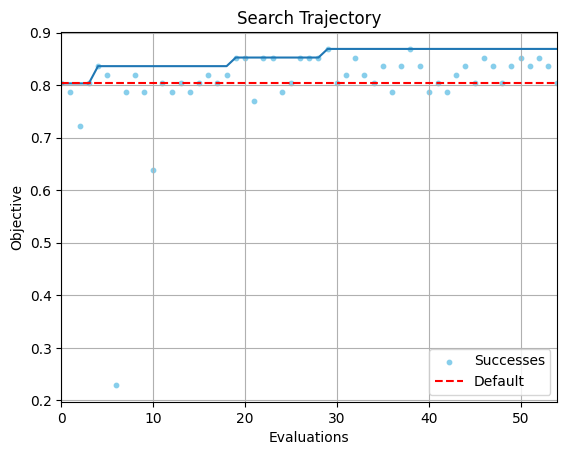

In [22]:
import matplotlib.pyplot as plt
from deephyper.analysis.hpo import plot_search_trajectory_single_objective_hpo

fig, ax = plot_search_trajectory_single_objective_hpo(results)
plt.axhline(results.iloc[0]["objective"], label="Default", color="red", linestyle="--")
plt.title("Search Trajectory")
plt.legend()
plt.show()  

Then, we can look at the best configuration.

In [20]:
i_max = results.objective.argmax()
best_job = results.iloc[i_max].to_dict()


print(f"The default configuration has an accuracy of {objective_default:.3f}. \n" 
      f"The best configuration found by DeepHyper has an accuracy {results['objective'].iloc[i_max]:.3f}, \n" 
      f"discovered after {results['m:timestamp_gather'].iloc[i_max]:.2f} secondes of search.\n")

best_job

The default configuration has an accuracy of 0.836. 
The best configuration found by DeepHyper has an accuracy 0.869, 
discovered after 92.86 secondes of search.



{'p:activation': 'hard_sigmoid',
 'p:batch_size': 254,
 'p:dropout_rate': 0.4811464422566914,
 'p:learning_rate': 0.0054377979900459,
 'p:num_epochs': 22,
 'p:units': 107,
 'objective': 0.868852436542511,
 'job_id': 29,
 'job_status': 'DONE',
 'm:timestamp_submit': 91.5409619808197,
 'm:loss': '[0.8287509083747864, 0.7461135983467102, 0.6655626893043518, 0.6344414949417114, 0.5947127938270569, 0.5709614753723145, 0.5807883739471436, 0.587151050567627, 0.5646253824234009, 0.6007587909698486, 0.5480071902275085, 0.5170748233795166, 0.5336693525314331, 0.4768647849559784, 0.47153279185295105, 0.4784860610961914, 0.4682762622833252, 0.46586450934410095, 0.43191930651664734, 0.44100987911224365, 0.4295496344566345, 0.4277530312538147]',
 'm:val_loss': '[0.695465087890625, 0.6011614799499512, 0.5411741137504578, 0.5071674585342407, 0.49052631855010986, 0.48139819502830505, 0.4735262393951416, 0.46430036425590515, 0.4532046914100647, 0.4405619502067566, 0.4278675317764282, 0.4162490665912628,

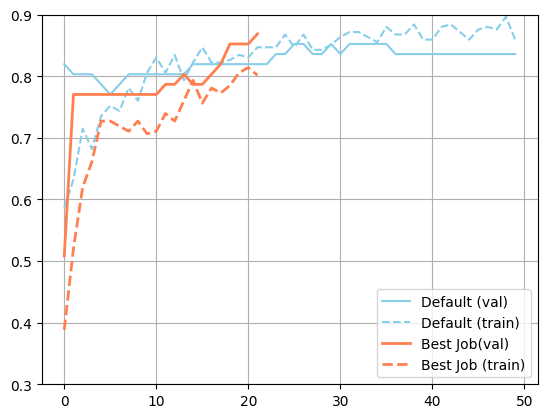

In [21]:
plt.figure()
plt.plot(json.loads(metadata_default["val_accuracy"]), color="skyblue", label="Default (val)")
plt.plot(json.loads(metadata_default["accuracy"]), color="skyblue", linestyle="--", label="Default (train)")
plt.plot(json.loads(best_job["m:val_accuracy"]), color="coral", linewidth=2, label="Best Job(val)")
plt.plot(json.loads(best_job["m:accuracy"]), color="coral", linestyle="--", linewidth=2, label="Best Job (train)")
plt.legend()
plt.ylim(0.3, 0.9)
plt.grid()
plt.show()

## Restart from a checkpoint

It can often be useful to continue the search from previous results. For example, if the allocation requested was not enough or if an unexpected crash happened. The `CBO` search provides the `fit_surrogate(dataframe_of_results)` method for this use case. 

To simulate this we create a second evaluator `evaluator_2` and start a fresh CBO search with strong explotation `kappa=0.001`.

In [ ]:
# Create a new evaluator
evaluator_2 = get_evaluator(run)

# Create a new CBO search with strong explotation (i.e., small kappa)
search_from_checkpoint = CBO(
    problem, 
    evaluator_2, 
    acq_func="UCBd", 
    kappa=0.001, 
    acq_optimizer="mixedga", 
    acq_optimizer_freq=1,
)

# Initialize surrogate model of Bayesian optization 
# With results of previous search
search_from_checkpoint.fit_surrogate(results)

Created new evaluator with 1 worker and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.TqdmCallback object at 0x3c94ecb90>]}


In [24]:
results_from_checkpoint = search_from_checkpoint.search(max_evals=25)

  0%|          | 0/25 [00:00<?, ?it/s]

In [25]:
results_from_checkpoint

,p:activation,p:batch_size,p:dropout_rate,p:learning_rate,p:num_epochs,p:units,objective,job_id,job_status,m:timestamp_submit,m:loss,m:val_loss,m:accuracy,m:val_accuracy,m:num_parameters,m:num_parameters_train,m:timestamp_gather
0,hard_sigmoid,208,0.478206,0.005454,22,107,0.819672,0,DONE,33.978275,"[0.9971071481704712, 0.7485412955284119, 0.662...","[0.7065404653549194, 0.5395659804344177, 0.486...","[0.3471074402332306, 0.4958677589893341, 0.628...","[0.4754098355770111, 0.7704917788505554, 0.770...",18,4067,35.390350
1,hard_sigmoid,253,0.473896,0.006269,17,127,0.819672,1,DONE,35.950736,"[1.3935201168060303, 1.0515316724777222, 0.836...","[1.0693024396896362, 0.8184766173362732, 0.641...","[0.2933884263038635, 0.3016528785228729, 0.446...","[0.2295081913471222, 0.2295081913471222, 0.737...",18,4827,37.273664
2,hard_sigmoid,254,0.481205,0.005385,22,108,0.836066,2,DONE,39.145892,"[1.0258198976516724, 0.8684240579605103, 0.718...","[0.8224217295646667, 0.6814082264900208, 0.581...","[0.3264462947845459, 0.41735535860061646, 0.50...","[0.2295081913471222, 0.6229507923126221, 0.819...",18,4105,40.475309
3,gelu,212,0.524199,0.009018,27,116,0.786885,3,DONE,41.019375,"[0.8138331770896912, 0.5084949135780334, 0.424...","[0.494068443775177, 0.3931865990161896, 0.3644...","[0.40082645416259766, 0.7685950398445129, 0.77...","[0.8032786846160889, 0.8032786846160889, 0.786...",18,4409,42.734825
4,hard_sigmoid,217,0.524250,0.007515,28,114,0.836066,4,DONE,43.419275,"[1.0927315950393677, 0.7291306853294373, 0.562...","[0.6644625663757324, 0.5093420743942261, 0.467...","[0.3140496015548706, 0.5, 0.7314049601554871, ...","[0.6721311211585999, 0.7704917788505554, 0.770...",18,4333,44.829498
5,hard_sigmoid,255,0.481120,0.008677,22,107,0.852459,5,DONE,45.742031,"[0.6349105834960938, 0.6272992491722107, 0.558...","[0.5131592750549316, 0.4829488694667816, 0.457...","[0.6900826692581177, 0.702479362487793, 0.7107...","[0.7704917788505554, 0.7704917788505554, 0.770...",18,4067,47.083459
6,hard_sigmoid,223,0.482572,0.009001,22,124,0.836066,6,DONE,47.650057,"[1.2967249155044556, 0.7333991527557373, 0.593...","[0.7114768624305725, 0.48710745573043823, 0.49...","[0.2975206673145294, 0.5206611752510071, 0.698...","[0.4098360538482666, 0.7704917788505554, 0.770...",18,4713,48.999962
7,hard_sigmoid,254,0.101842,0.005435,22,102,0.836066,7,DONE,49.465036,"[0.9877975583076477, 0.8333274722099304, 0.716...","[0.8490940928459167, 0.711073637008667, 0.6106...","[0.2851239740848541, 0.2933884263038635, 0.491...","[0.2295081913471222, 0.3606557250022888, 0.754...",18,3877,50.795491
8,hard_sigmoid,254,0.467120,0.005438,22,107,0.852459,8,DONE,52.233492,"[0.6846663951873779, 0.6341745257377625, 0.613...","[0.5275814533233643, 0.5193657875061035, 0.509...","[0.71074378490448, 0.7066115736961365, 0.68181...","[0.7704917788505554, 0.7704917788505554, 0.770...",18,4067,53.847407
9,hard_sigmoid,252,0.209863,0.006543,19,124,0.852459,9,DONE,54.733154,"[0.6476067900657654, 0.5874485373497009, 0.560...","[0.5384824872016907, 0.5076740980148315, 0.476...","[0.71074378490448, 0.7148760557174683, 0.73553...","[0.7704917788505554, 0.7704917788505554, 0.770...",18,4713,56.087044


In [26]:
i_max = results_from_checkpoint.objective.argmax()
best_job = results_from_checkpoint.iloc[i_max].to_dict()


print(f"The default configuration has an accuracy of {objective_default:.3f}. \n" 
      f"The best configuration found by DeepHyper has an accuracy {results_from_checkpoint['objective'].iloc[i_max]:.3f}, \n" 
      f"discovered after {results_from_checkpoint['m:timestamp_gather'].iloc[i_max]:.2f} secondes of search.\n")

best_job

The default configuration has an accuracy of 0.836. 
The best configuration found by DeepHyper has an accuracy 0.852, 
discovered after 47.08 secondes of search.



{'p:activation': 'hard_sigmoid',
 'p:batch_size': 255,
 'p:dropout_rate': 0.481119568066835,
 'p:learning_rate': 0.0086765454003444,
 'p:num_epochs': 22,
 'p:units': 107,
 'objective': 0.8524590134620667,
 'job_id': 5,
 'job_status': 'DONE',
 'm:timestamp_submit': 45.74203109741211,
 'm:loss': '[0.6349105834960938, 0.6272992491722107, 0.5584259629249573, 0.5526432394981384, 0.5168532133102417, 0.5305481553077698, 0.4433193504810333, 0.45578300952911377, 0.4224569797515869, 0.42115506529808044, 0.41517341136932373, 0.40223243832588196, 0.3649812936782837, 0.3698986768722534, 0.38615867495536804, 0.34518924355506897, 0.3437093496322632, 0.3397452235221863, 0.35441818833351135, 0.33848950266838074, 0.30461177229881287, 0.34012123942375183]',
 'm:val_loss': '[0.5131592750549316, 0.4829488694667816, 0.4570136070251465, 0.43298590183258057, 0.41293779015541077, 0.3986186981201172, 0.3872995972633362, 0.37787696719169617, 0.3706487715244293, 0.36465173959732056, 0.36144769191741943, 0.3592358

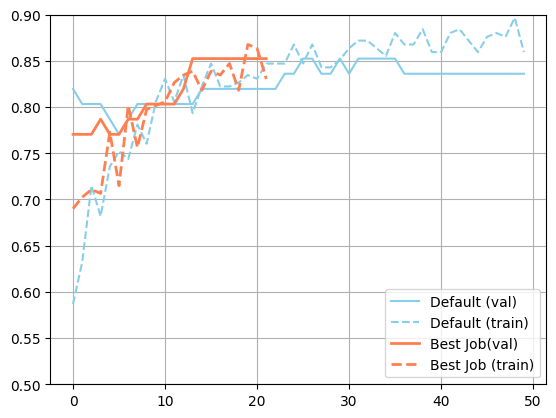

In [27]:
plt.figure()
plt.plot(json.loads(metadata_default["val_accuracy"]), color="skyblue", label="Default (val)")
plt.plot(json.loads(metadata_default["accuracy"]), color="skyblue", linestyle="--", label="Default (train)")
plt.plot(json.loads(best_job["m:val_accuracy"]), color="coral", linewidth=2, label="Best Job(val)")
plt.plot(json.loads(best_job["m:accuracy"]), color="coral", linestyle="--", linewidth=2, label="Best Job (train)")
plt.legend()
plt.ylim(0.5, 0.9)
plt.grid()
plt.show()

## Add conditional hyperparameters

Now we want to add the possibility to search for a second fully-connected layer. We simply add two new lines:

```python
if config.get("dense_2", False):
    x = tfk.layers.Dense(config["dense_2:units"], activation=config["dense_2:activation"])(x)
```

In [29]:
def run_with_condition(config: dict):
    tf.autograph.set_verbosity(0)
    
    train_dataframe, val_dataframe = load_data()

    train_ds = dataframe_to_dataset(train_dataframe)
    val_ds = dataframe_to_dataset(val_dataframe)

    train_ds = train_ds.batch(config["batch_size"])
    val_ds = val_ds.batch(config["batch_size"])

    # Categorical features encoded as integers
    sex = tfk.Input(shape=(1,), name="sex", dtype="int64")
    cp = tfk.Input(shape=(1,), name="cp", dtype="int64")
    fbs = tfk.Input(shape=(1,), name="fbs", dtype="int64")
    restecg = tfk.Input(shape=(1,), name="restecg", dtype="int64")
    exang = tfk.Input(shape=(1,), name="exang", dtype="int64")
    ca = tfk.Input(shape=(1,), name="ca", dtype="int64")

    # Categorical feature encoded as string
    thal = tfk.Input(shape=(1,), name="thal", dtype="string")

    # Numerical features
    age = tfk.Input(shape=(1,), name="age")
    trestbps = tfk.Input(shape=(1,), name="trestbps")
    chol = tfk.Input(shape=(1,), name="chol")
    thalach = tfk.Input(shape=(1,), name="thalach")
    oldpeak = tfk.Input(shape=(1,), name="oldpeak")
    slope = tfk.Input(shape=(1,), name="slope")

    all_inputs = [
        sex,
        cp,
        fbs,
        restecg,
        exang,
        ca,
        thal,
        age,
        trestbps,
        chol,
        thalach,
        oldpeak,
        slope,
    ]

    # Integer categorical features
    sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
    cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
    fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
    restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
    exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
    ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

    # String categorical features
    thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

    # Numerical features
    age_encoded = encode_numerical_feature(age, "age", train_ds)
    trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
    chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
    thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
    oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
    slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

    all_features = tfk.layers.concatenate(
        [
            sex_encoded,
            cp_encoded,
            fbs_encoded,
            restecg_encoded,
            exang_encoded,
            slope_encoded,
            ca_encoded,
            thal_encoded,
            age_encoded,
            trestbps_encoded,
            chol_encoded,
            thalach_encoded,
            oldpeak_encoded,
        ]
    )
    x = tfk.layers.Dense(config["units"], activation=config["activation"])(
        all_features
    )

    ### START - NEW LINES
    if config.get("dense_2", False):
        x = tfk.layers.Dense(config["dense_2:units"], activation=config["dense_2:activation"])(x)
    ### END - NEW LINES

    x = tfk.layers.Dropout(config["dropout_rate"])(x)
    output = tfk.layers.Dense(1, activation="sigmoid")(x)
    model = tfk.Model(all_inputs, output)

    optimizer = tfk.optimizers.Adam(learning_rate=config["learning_rate"])
    model.compile(optimizer, "binary_crossentropy", metrics=["accuracy"])

    try:
        history = model.fit(
            train_ds, epochs=config["num_epochs"], validation_data=val_ds, verbose=0
        )
    except:
        class History:
            history = {
                "accuracy": None,
                "val_accuracy": ["F_fit"],
                "loss": None,
                "val_loss": None,
            }

        history = History()

    objective = history.history["val_accuracy"][-1]
    metadata = {
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
    }
    metadata = {k:json.dumps(v) for k,v in metadata.items()}
    metadata.update(count_params(model))

    return {"objective": objective, "metadata": metadata}

To define conditionnal hyperparameters we use [ConfigSpace](https://automl.github.io/ConfigSpace/master/index.html). We define `dense_2:units` and `dense_2:activation` as active hyperparameters only when `dense_2 == True`. The `cs.EqualsCondition` help us do that. Then we call

```python
problem_with_condition.add_condition(condition)
```

to register each new condition to the `HpProblem`.

In [30]:
from ConfigSpace import EqualsCondition

# Define the hyperparameter problem
problem_with_condition = HpProblem()


# Define the same hyperparameters as before
problem_with_condition.add_hyperparameter((8, 128), "units")
problem_with_condition.add_hyperparameter(ACTIVATIONS, "activation")
problem_with_condition.add_hyperparameter((0.0, 0.6), "dropout_rate")
problem_with_condition.add_hyperparameter((10, 100), "num_epochs")
problem_with_condition.add_hyperparameter((8, 256, "log-uniform"), "batch_size")
problem_with_condition.add_hyperparameter((1e-5, 1e-2, "log-uniform"), "learning_rate")


# Add a new hyperparameter "dense_2 (bool)" to decide if a second fully-connected layer should be created
hp_dense_2 = problem_with_condition.add_hyperparameter([True, False], "dense_2")
hp_dense_2_units = problem_with_condition.add_hyperparameter((8, 128), "dense_2:units")
hp_dense_2_activation = problem_with_condition.add_hyperparameter(ACTIVATIONS, "dense_2:activation")

problem_with_condition.add_condition(EqualsCondition(hp_dense_2_units, hp_dense_2, True))
problem_with_condition.add_condition(EqualsCondition(hp_dense_2_activation, hp_dense_2, True))


problem_with_condition

Configuration space object:
  Hyperparameters:
    activation, Type: Categorical, Choices: {elu, gelu, hard_sigmoid, linear, relu, selu, sigmoid, softplus, softsign, swish, tanh}, Default: elu
    batch_size, Type: UniformInteger, Range: [8, 256], Default: 45, on log-scale
    dense_2, Type: Categorical, Choices: {True, False}, Default: True
    dense_2:activation, Type: Categorical, Choices: {elu, gelu, hard_sigmoid, linear, relu, selu, sigmoid, softplus, softsign, swish, tanh}, Default: elu
    dense_2:units, Type: UniformInteger, Range: [8, 128], Default: 68
    dropout_rate, Type: UniformFloat, Range: [0.0, 0.6], Default: 0.3
    learning_rate, Type: UniformFloat, Range: [1e-05, 0.01], Default: 0.000316227766, on log-scale
    num_epochs, Type: UniformInteger, Range: [10, 100], Default: 55
    units, Type: UniformInteger, Range: [8, 128], Default: 68
  Conditions:
    dense_2:activation | dense_2 == True
    dense_2:units | dense_2 == True

We create a new evaluator `evaluator_3` and start a fresh CBO search with this new problem `problem_with_condition`.

In [32]:
evaluator_3 = get_evaluator(run_with_condition)

search_with_condition = CBO(
    problem_with_condition, 
    evaluator_3,    
    acq_func="UCBd", 
    acq_optimizer="mixedga", 
    acq_optimizer_freq=1,
)

Created new evaluator with 1 worker and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.TqdmCallback object at 0x3cb0dee70>]}


In [33]:
results_with_condition = search_with_condition.search(max_evals=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [34]:
results_with_condition

,p:activation,p:batch_size,p:dense_2,p:dropout_rate,p:learning_rate,p:num_epochs,p:units,p:dense_2:activation,p:dense_2:units,objective,job_id,job_status,m:timestamp_submit,m:loss,m:val_loss,m:accuracy,m:val_accuracy,m:num_parameters,m:num_parameters_train,m:timestamp_gather
0,tanh,15,True,0.366818,0.005029,26,60,softplus,105,0.7704917788505554,0,DONE,11.082239,"[0.5009121298789978, 0.3078427314758301, 0.338...","[0.4244871735572815, 0.5283817648887634, 0.486...","[0.7479338645935059, 0.8512396812438965, 0.863...","[0.8360655903816223, 0.8360655903816223, 0.819...",18,8731,12.913492
1,tanh,8,True,0.390801,0.000175,81,30,hard_sigmoid,68,0.8032786846160889,1,DONE,13.528550,"[0.604907214641571, 0.5923880338668823, 0.5909...","[0.5101694464683533, 0.4980083405971527, 0.486...","[0.71074378490448, 0.7231404781341553, 0.70661...","[0.7704917788505554, 0.7704917788505554, 0.770...",18,3287,17.357964
2,tanh,114,False,0.196952,0.000011,17,100,elu,8,0.4754098355770111,2,DONE,18.065723,"[0.7861196994781494, 0.7642049789428711, 0.761...","[0.7636403441429138, 0.7626331448554993, 0.761...","[0.40909090638160706, 0.45041322708129883, 0.4...","[0.44262295961380005, 0.44262295961380005, 0.4...",18,3801,19.381279
3,selu,115,False,0.077023,0.000019,25,50,elu,8,0.32786884903907776,3,DONE,19.988189,"[0.9111230969429016, 0.9428355097770691, 0.920...","[0.9447649121284485, 0.9423429369926453, 0.940...","[0.37603306770324707, 0.3636363744735718, 0.37...","[0.2950819730758667, 0.2950819730758667, 0.295...",18,1901,21.368746
4,relu,73,False,0.476480,0.003393,19,34,elu,8,0.8032786846160889,4,DONE,21.978687,"[0.7194283604621887, 0.6411665678024292, 0.568...","[0.6180158257484436, 0.5356436967849731, 0.484...","[0.5413222908973694, 0.6611570119857788, 0.698...","[0.6393442749977112, 0.688524603843689, 0.7540...",18,1293,23.331681
5,selu,125,False,0.534733,0.000035,84,74,elu,8,0.6721311211585999,5,DONE,23.939715,"[0.7867716550827026, 0.7413351535797119, 0.748...","[0.7112182378768921, 0.7088605761528015, 0.706...","[0.557851254940033, 0.6074380278587341, 0.5619...","[0.49180328845977783, 0.49180328845977783, 0.4...",18,2813,25.724129
6,softplus,65,False,0.568267,0.004382,34,30,elu,8,0.8360655903816223,6,DONE,26.333320,"[0.7672441005706787, 0.6641848087310791, 0.563...","[0.4976312518119812, 0.45320722460746765, 0.42...","[0.5991735458374023, 0.6611570119857788, 0.727...","[0.8032786846160889, 0.8032786846160889, 0.786...",18,1141,27.797871
7,linear,55,False,0.162118,0.000082,50,44,elu,8,0.7377049326896667,7,DONE,28.413964,"[0.7725011110305786, 0.7690296769142151, 0.750...","[0.7852056622505188, 0.7744285464286804, 0.763...","[0.44628098607063293, 0.4834710657596588, 0.52...","[0.3442623019218445, 0.3606557250022888, 0.393...",18,1673,30.404005
8,hard_sigmoid,11,True,0.352241,0.000210,99,61,elu,125,0.8196721076965332,8,DONE,31.013985,"[0.7297561168670654, 0.5910099148750305, 0.583...","[0.5413499474525452, 0.5040895342826843, 0.501...","[0.5165289044380188, 0.7190082669258118, 0.719...","[0.7704917788505554, 0.7704917788505554, 0.770...",18,10133,34.436101
9,gelu,185,False,0.341791,0.003917,65,17,elu,8,0.8032786846160889,9,DONE,35.063485,"[0.7614551186561584, 0.7111193537712097, 0.664...","[0.6993500590324402, 0.6591216921806335, 0.622...","[0.4710743725299835, 0.5454545617103577, 0.648...","[0.6229507923126221, 0.6393442749977112, 0.655...",18,647,36.736329


Finally, let us print out the best configuration found from this conditionned search space.

In [37]:
from deephyper.analysis.hpo import filter_failed_objectives

results_with_condition_without_failure, _ = filter_failed_objectives(results_with_condition)
i_max = results_with_condition_without_failure.objective.argmax()
best_job = results_with_condition_without_failure.iloc[i_max].to_dict()


print(f"The default configuration has an accuracy of {objective_default:.3f}. \n" 
      f"The best configuration found by DeepHyper has an accuracy {results_with_condition_without_failure['objective'].iloc[i_max]:.3f}, \n" 
      f"discovered after {results_with_condition_without_failure['m:timestamp_gather'].iloc[i_max]:.2f} secondes of search.\n")

best_job

The default configuration has an accuracy of 0.836. 
The best configuration found by DeepHyper has an accuracy 0.869, 
discovered after 97.06 secondes of search.



{'p:activation': 'softplus',
 'p:batch_size': 151,
 'p:dense_2': False,
 'p:dropout_rate': 0.5712985151526,
 'p:learning_rate': 0.0023551435679,
 'p:num_epochs': 37,
 'p:units': 30,
 'p:dense_2:activation': 'elu',
 'p:dense_2:units': 8,
 'objective': 0.868852436542511,
 'job_id': 26,
 'job_status': 'DONE',
 'm:timestamp_submit': 95.61813306808472,
 'm:loss': '[0.9386454820632935, 0.8260695934295654, 0.8045966029167175, 0.794924259185791, 0.7922928929328918, 0.71309894323349, 0.674532949924469, 0.6240278482437134, 0.5885002017021179, 0.5997695922851562, 0.5670955181121826, 0.614417552947998, 0.5098029375076294, 0.511737585067749, 0.5198138952255249, 0.5427704453468323, 0.5118103623390198, 0.5001246929168701, 0.48275113105773926, 0.4626578986644745, 0.4975070357322693, 0.4643486738204956, 0.42703598737716675, 0.4019463360309601, 0.44776079058647156, 0.4671458303928375, 0.43884947896003723, 0.4610165059566498, 0.4526631236076355, 0.3922064006328583, 0.434793084859848, 0.41919174790382385,

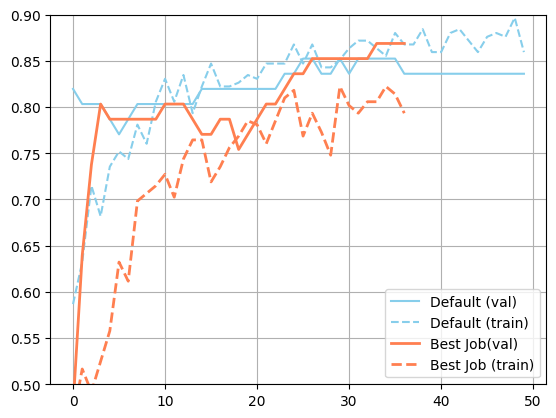

In [38]:
lt.figure()
plt.plot(json.loads(metadata_default["val_accuracy"]), color="skyblue", label="Default (val)")
plt.plot(json.loads(metadata_default["accuracy"]), color="skyblue", linestyle="--", label="Default (train)")
plt.plot(json.loads(best_job["m:val_accuracy"]), color="coral", linewidth=2, label="Best Job(val)")
plt.plot(json.loads(best_job["m:accuracy"]), color="coral", linestyle="--", linewidth=2, label="Best Job (train)")
plt.legend()
plt.ylim(0.5, 0.9)
plt.grid()
plt.show()